In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/FinSightAI/data/financial_data.csv', index_col=0, header=[0,1], parse_dates=True)  # Load from CSV
# Cleaning
data.fillna(method='ffill', inplace=True)  # Forward fill missing (none in synthetic)
data = data.asfreq('B')  # Business days

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-4073447233.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing (none in synthetic)


In [28]:
# Calculate daily returns and create a new DataFrame for them
returns_df = pd.DataFrame(index=data.index)
for ticker in ['TSLA', 'BND', 'SPY']:
    returns_df[(ticker, 'Return')] = data[(ticker, 'Adj Close')].pct_change()

# Identify and drop existing 'Return' columns from the original data DataFrame
# This handles cases where 'Return' might have been added in previous runs or different ways
cols_to_drop = [col for col in data.columns if col[1] == 'Return']
if cols_to_drop:
    data = data.drop(columns=cols_to_drop)

# Concatenate the original data DataFrame (without old 'Return' columns) with the new returns_df
data = pd.concat([data, returns_df], axis=1)

# Sort the column index to ensure consistency for MultiIndex access
data.sort_index(axis=1, inplace=True)


# Display column index and levels for debugging
print("Data columns:", data.columns)
print("Column index levels:", data.columns.levels)
print("Column index names:", data.columns.names)
print("Column index level 0 values:", data.columns.get_level_values(0))
print("Column index level 1 values:", data.columns.get_level_values(1))

# Print exact string representation and length of level 1 values
print("\nExact string representation and length of level 1 values:")
for name in data.columns.get_level_values(1):
    print(f"'{name}' (Type: {type(name)}, Length: {len(str(name))})")


# Basic stats
stats = data.xs('Adj Close', level=1, axis=1).describe()

Data columns: MultiIndex([( 'BND', 'Adj Close'),
            ( 'BND',     'Close'),
            ( 'BND',      'High'),
            ( 'BND',       'Low'),
            ( 'BND',      'Open'),
            ( 'BND',    'Return'),
            ( 'BND',    'Volume'),
            ( 'SPY', 'Adj Close'),
            ( 'SPY',     'Close'),
            ( 'SPY',      'High'),
            ( 'SPY',       'Low'),
            ( 'SPY',      'Open'),
            ( 'SPY',    'Return'),
            ( 'SPY',    'Volume'),
            ('TSLA', 'Adj Close'),
            ('TSLA',     'Close'),
            ('TSLA',      'High'),
            ('TSLA',       'Low'),
            ('TSLA',      'Open'),
            ('TSLA',    'Return'),
            ('TSLA',    'Volume')],
           )
Column index levels: [['BND', 'SPY', 'TSLA'], ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Return', 'Volume']]
Column index names: [None, None]
Column index level 0 values: Index(['BND', 'BND', 'BND', 'BND', 'BND', 'BND', 'BND', 'SPY',

<Figure size 1200x600 with 0 Axes>

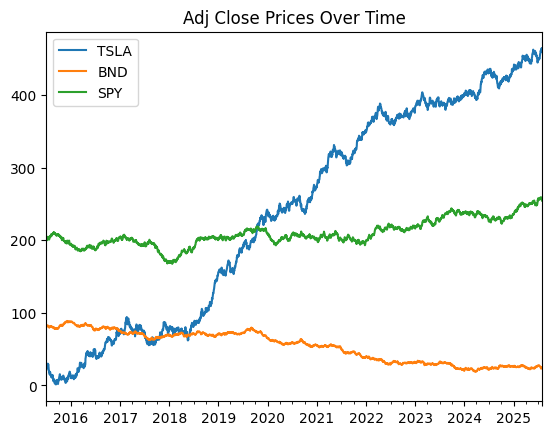

In [16]:
# EDA Visualizations
plt.figure(figsize=(12,6))
data.xs('Adj Close', level=1, axis=1).plot()
plt.title('Adj Close Prices Over Time')
plt.savefig('/content/drive/MyDrive/FinSightAI/plots/adj_close_trends.png')

/tmp/ipython-input-2018639482.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  rolling_vol.plot()
/tmp/ipython-input-2018639482.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  rolling_vol.plot()
/tmp/ipython-input-2018639482.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  rolling_vol.plot()
/tmp/ipython-input-2018639482.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  rolling_vol.plot()
/tmp/ipython-input-2018639482.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  rolling_vol.plot()
/tmp/ipython-input-2018639482.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  rolling_vol.plot()
/tmp/ipython-input-2018639482.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  rolling_vol.plot()
/tmp/ipython-input-2018639482.py:3: PerformanceWarning: indexing past lexsort depth may impact pe

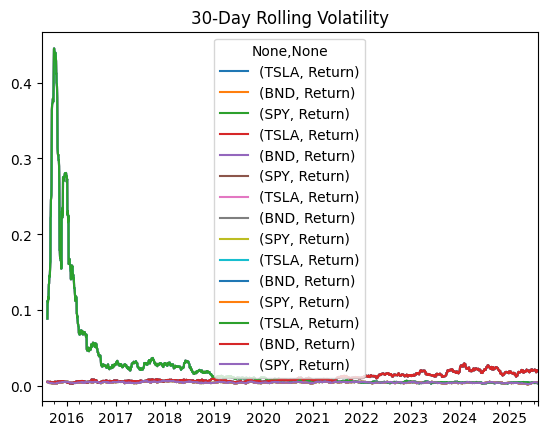

In [23]:
# Volatility: Rolling 30-day std of returns
rolling_vol = data.filter(like='Return', axis=1).rolling(30).std()
rolling_vol.plot()
plt.title('30-Day Rolling Volatility')
plt.savefig('/content/drive/MyDrive/FinSightAI/plots/volatility.png')

In [29]:
# Outliers: Returns beyond 3 std
outliers = data[('TSLA', 'Return')][np.abs(data[('TSLA', 'Return')] > 3 * data[('TSLA', 'Return')].std())]

# Stationarity test (ADF on TSLA Adj Close and Return)
adf_close = adfuller(data[('TSLA', 'Adj Close')])
adf_return = adfuller(data[('TSLA', 'Return')].dropna())

In [30]:
# Risk metrics
var_5 = data[('TSLA', 'Return')].quantile(0.05)  # VaR at 5%
sharpe = data[('TSLA', 'Return')].mean() / data[('TSLA', 'Return')].std() * np.sqrt(252)  # Annualized, rf=0

print(stats)
print(f'ADF Close: stat={adf_close[0]:.2f}, p={adf_close[1]:.2f}')
print(f'ADF Return: stat={adf_return[0]:.2f}, p={adf_return[1]:.2f}')
print(f'VaR 5%: {var_5:.4f}, Sharpe: {sharpe:.2f}')
print(f'Outliers: {len(outliers)} days')

               BND          SPY         TSLA
count  2632.000000  2632.000000  2632.000000
mean     53.694583   209.831690   238.481998
std      21.267002    18.371110   148.524238
min      18.829500   167.407542     1.276769
25%      30.783477   198.772421    77.640603
50%      58.245384   205.302378   248.487283
75%      71.815091   220.230246   384.976289
max      88.750193   259.000450   464.038546
ADF Close: stat=-0.22, p=0.94
ADF Return: stat=-10.08, p=0.00
VaR 5%: -0.0366, Sharpe: 0.75
Outliers: 27 days
